In [ ]:
!pip install transformers==4.37.2
!pip install tensorflow==2.15.0
!pip install matplotlib
!pip install pandas
!pip install scikit-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.4/8.4 MB 15.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 23.3 MB/s eta 0:00:00
  Attempting uninstall: tokenizers
    Found existing installation: tokenizers 0.19.1
    Uninstalling tokenizers-0.19.1:
      Successfully uninstalled tokenizers-0.19.1
  Attempting uninstall: transformers
    Found existing installation: transformers 4.41.2
    Uninstalling transformers-4.41.2:
      Successfully uninstalled transformers-4.41.2


### Mount Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Import our dependencies

In [ ]:
import tensorflow as tf
import numpy as np
import pandas as pd
from transformers import DistilBertTokenizer, TFDistilBertModel
import os
import matplotlib.pyplot as plt
import pickle
from sklearn.utils.class_weight import compute_class_weight

In [ ]:
tf.config.run_functions_eagerly(True)
tf.data.experimental.enable_debug_mode()

### Change directory

In [ ]:
os.chdir('./drive/MyDrive/DTX')

### Load dataset and split in train and test

In [ ]:
def load_data():
    # Load dataset and split in train and test data
    df = pd.read_csv('dataframe.csv', delimiter=';')

    #df['label'] = df['label'].replace({'Highlight': 1, 'Non-Highlight': 0})
    counts = pd.value_counts(df['label'])
    print(counts)

    # We use 10% of the data for testing
    test_ratio = 0.1
    df_rows = df.shape[0]
    test_index = df_rows - int(test_ratio * df_rows)

    one_hot_encoding = {
        'Non-Highlight' : [1, 0],
        'Highlight'     : [0, 1]
    }


    # Step 1: Filter the Data
    highlights_df = df[df['label'] == 'Highlight']
    non_highlights_df = df[df['label'] == 'Non-Highlight']

    # Step 2: Sample the Data
    # Ensure reproducibility with `random_state`
    train_highlights = highlights_df.sample(n=120, random_state=1)
    test_highlights = highlights_df.drop(train_highlights.index).sample(n=32, random_state=1)

    train_non_highlights = non_highlights_df.sample(n=120, random_state=1)
    test_non_highlights = non_highlights_df.drop(train_non_highlights.index).sample(n=32, random_state=1)

    # Step 3: Combine the Data
    train_data = pd.concat([train_highlights, train_non_highlights]).sample(frac=1, random_state=1).reset_index(drop=True)
    test_data = pd.concat([test_highlights, test_non_highlights]).sample(frac=1, random_state=1).reset_index(drop=True)

    x_train = train_data['commentary']
    y_train = [one_hot_encoding[row['label']]  for index, row in train_data.iterrows()]

    x_test = test_data['commentary']
    y_test = [one_hot_encoding[row['label']]  for index, row in test_data.iterrows()]


    """
    x_train = df['commentary'][0:test_index]
    y_train = [ one_hot_encoding[df['label'][i]] for i in range(test_index)]

    x_test = df['commentary'][test_index:]
    y_test = [ one_hot_encoding[df['label'][i]] for i in range(test_index, df_rows)]
    """

    return counts, np.array(x_train), np.array(y_train), np.array(x_test), np.array(y_test)

load_data()

# Encode Bert output to pass as input to our MLP
def encode_data(data, tokenizer, max_length=512):
    encodings = tokenizer(list(data), truncation=True, padding=True, max_length=max_length)

    input_ids = np.array(encodings['input_ids'])
    attention_masks = np.array(encodings['attention_mask'])

    return input_ids, attention_masks

label
Non-Highlight    1915
Highlight         152
Name: count, dtype: int64


### Creade model Bert + MLP

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertModel: ['vocab_layer_norm.weight', 'vocab_transform.bias', 'vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_transform.weight']
- This IS expected if you are initializing TFDistilBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFDistilBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


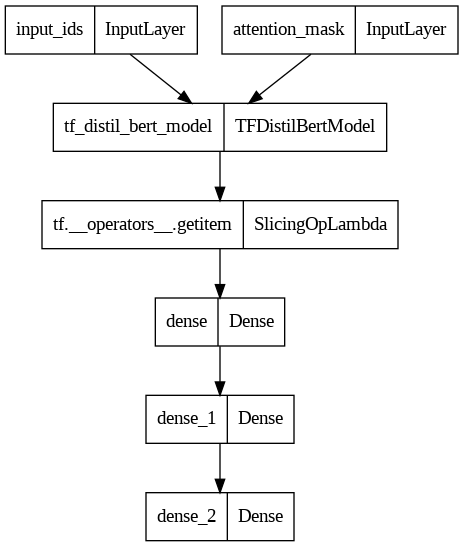

In [ ]:
import tensorflow as tf
from transformers import DistilBertTokenizer, TFDistilBertModel
from sklearn.metrics import precision_score, recall_score
import numpy as np
from keras.utils import plot_model

# Create a custom model, Bert + MLP
def create_model(bert_model_name, num_classes):
    tokenizer = DistilBertTokenizer.from_pretrained(bert_model_name)
    bert_model = TFDistilBertModel.from_pretrained(bert_model_name)

    input_ids = tf.keras.Input(shape=(None,), dtype=tf.int64, name='input_ids')
    attention_mask = tf.keras.Input(shape=(None,), dtype=tf.int64, name='attention_mask')

    # Obter a saída do modelo transformer
    bert_output = bert_model([input_ids, attention_mask])
    sequence_output = bert_output.last_hidden_state

    # Selecionar a representação do token [CLS]
    cls_token = sequence_output[:, 0, :]

    # Adicionar camadas densas para classificação
    x = tf.keras.layers.Dense(64, activation='relu')(cls_token)
    x = tf.keras.layers.Dense(128, activation='relu')(x)

    output = tf.keras.layers.Dense(num_classes, activation='softmax')(x)

    model = tf.keras.Model(inputs=[input_ids, attention_mask], outputs=output)

    return model, tokenizer

bert_model_name = 'distilbert-base-uncased'
num_classes = 2
custom_model, tokenizer = create_model(bert_model_name, num_classes)

custom_model.compile(
    optimizer='adam',
    loss=tf.keras.losses.categorical_crossentropy,
    metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
)


plot_model(custom_model)

### Train model

In [ ]:
counts, x_train, y_train, x_test, y_test = load_data()

# Load input ids and attention masks
train_input_ids, train_attention_masks = encode_data(x_train, tokenizer)
test_input_ids, test_attention_masks = encode_data(x_test, tokenizer)

epochs = 20
batch_size = 64


total = counts[0] + counts[1]
weight_for_non_highlight = (1. / counts[0]) * (total / 2.0)
weight_for_highlight = (1. / counts[1]) * (total / 2.0)


class_weights = {
    0: 0.2,
    1: 2
}

"""
y = np.argmax(y_train, axis=1)
class_weights = compute_class_weight('balanced', classes=np.unique(y), y=y)
class_weights = dict(enumerate(class_weights))
"""
print("\nclass weights\n" ,class_weights)




label
Non-Highlight    1915
Highlight         152
Name: count, dtype: int64

class weights
 {0: 0.2, 1: 2}


In [ ]:
# Train the model
history = custom_model.fit(
    x=[train_input_ids, train_attention_masks],
    y=y_train,
    validation_split=0.2,
    epochs=epochs,
    batch_size=batch_size,
    class_weight=class_weights
)

Epoch 1/20
3/3 [==============================] - 262s 89s/step - loss: 0.5818 - accuracy: 0.5260 - precision: 0.5260 - recall: 0.5260 - val_loss: 0.9164 - val_accuracy: 0.5417 - val_precision: 0.5417 - val_recall: 0.5417
Epoch 2/20
3/3 [==============================] - 228s 80s/step - loss: 0.9546 - accuracy: 0.4792 - precision: 0.4792 - recall: 0.4792 - val_loss: 1.3079 - val_accuracy: 0.4583 - val_precision: 0.4583 - val_recall: 0.4583
Epoch 3/20
3/3 [==============================] - 227s 78s/step - loss: 0.3393 - accuracy: 0.5104 - precision: 0.5104 - recall: 0.5104 - val_loss: 1.5366 - val_accuracy: 0.4583 - val_precision: 0.4583 - val_recall: 0.4583
Epoch 4/20
3/3 [==============================] - 249s 89s/step - loss: 0.3328 - accuracy: 0.5104 - precision: 0.5104 - recall: 0.5104 - val_loss: 1.1989 - val_accuracy: 0.4583 - val_precision: 0.4583 - val_recall: 0.4583
Epoch 5/20
3/3 [==============================] - 227s 78s/step - loss: 0.3401 - accuracy: 0.5104 - precision: 0

### Predictions

In [ ]:
predictions = custom_model.predict(
    x=[test_input_ids, test_attention_masks],

)

for i, prediction in enumerate(predictions):
    print(prediction)



2/2 [==============================] - 20s 8s/step
[0.07944018 0.9205598 ]
[0.07944036 0.9205596 ]
[0.07944168 0.9205583 ]
[0.07944402 0.92055595]
[0.07944634 0.9205537 ]
[0.0794543  0.92054564]
[0.07944371 0.9205563 ]
[0.07944605 0.920554  ]
[0.07944338 0.9205566 ]
[0.07946316 0.92053676]
[0.07944442 0.92055565]
[0.07943944 0.9205606 ]
[0.07944748 0.92055255]
[0.07944265 0.92055726]
[0.07944752 0.92055243]
[0.07944281 0.92055714]
[0.07944217 0.9205578 ]
[0.0794512  0.92054886]
[0.07944784 0.92055213]
[0.07944539 0.9205545 ]
[0.07944059 0.92055947]
[0.07944168 0.9205583 ]
[0.07944104 0.9205589 ]
[0.0794384  0.92056155]
[0.07944039 0.9205596 ]
[0.07943619 0.92056376]
[0.07944295 0.92055696]
[0.07943928 0.9205608 ]
[0.07945002 0.9205499 ]
[0.07943808 0.92056197]
[0.07944128 0.9205587 ]
[0.07945124 0.92054874]
[0.07944353 0.9205565 ]
[0.0794417 0.9205583]
[0.07944003 0.9205599 ]
[0.07944203 0.9205579 ]
[0.07944315 0.92055684]
[0.07944094 0.92055905]
[0.07944025 0.9205597 ]
[0.07944055 0.9

### Confusion Matrix

In [ ]:
y_pred=np.argmax(predictions, axis=1)
y_test=np.argmax(y_test, axis=1)

print("y_pred\n" ,y_pred)
print("\ny_test\n", y_test)


y_pred
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]

y_test
 [1 0 0 1 0 1 1 0 0 0 0 0 0 1 0 0 1 0 0 1 0 1 0 0 1 0 0 0 0 0 1 0 1 1 0 1 0
 1 1 1 1 1 0 0 0 1 0 1 1 1 0 1 0 1 1 1 1 1 1 1 1 1 0 0]


### Plot our results and save in a folder

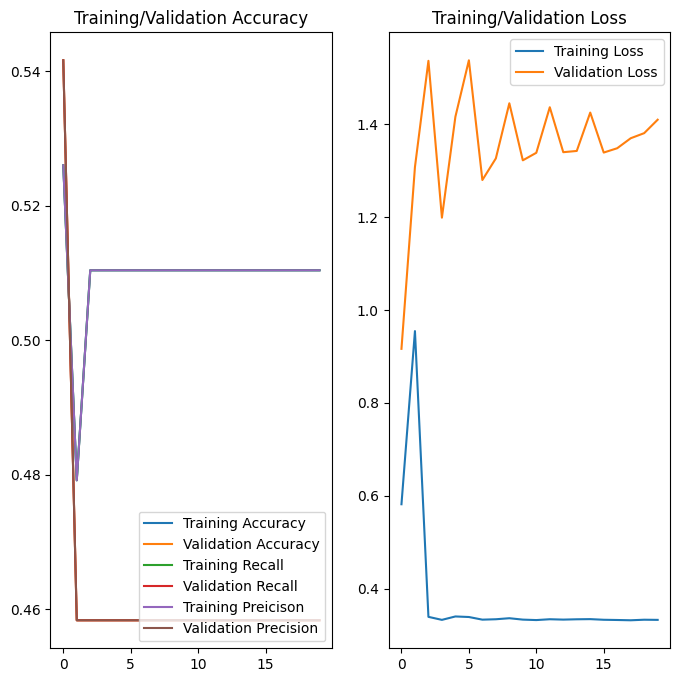

Saved artifact at './models/model_5/model'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): List[TensorSpec(shape=(None, None), dtype=tf.int64, name='input_ids'), TensorSpec(shape=(None, None), dtype=tf.int64, name='attention_mask')]
Output Type:
  TensorSpec(shape=(None, 2), dtype=tf.float32, name=None)
Captures:
  138058840750944: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138058840747952: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138058859743360: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138058861483056: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138058861484288: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138064156855280: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138058840627632: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138058840751120: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138058840626752: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1380588406258

In [ ]:
def plot_learning_curves(history, epochs, folderName):
    #accuracies and losses
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    recall = history.history['recall']
    val_recall = history.history['val_recall']

    precision = history.history['precision']
    val_precision = history.history['val_precision']

    epochs_range = range(epochs)

    #creating figure
    plt.figure(figsize=(8, 8))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')


    plt.legend(loc='lower right')
    plt.title('Training/Validation Accuracy')
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training/Validation Loss')
    plt.savefig(folderName + "/learning_curve.png")
    plt.show()


def plot_and_save(history, epochs, model):
    if not os.path.exists('models'):
        os.mkdir('models')

    num_models_saved = len(os.listdir('./models'))

    folderName = f'./models/model_{num_models_saved+1}'
    os.mkdir(folderName)
    plot_learning_curves(history, epochs, folderName)
    model.export(folderName + "/model")

plot_and_save(history, epochs, custom_model)